### This book condenses scipts into functions

In [57]:
CSV_PATH = "/home/zhimin90/CPT/CSVs/"

In [96]:
import pandas as pd
import numpy as np
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta


URL = 'https://data.cityofchicago.org/resource/wqdh-9gek.csv'
test_df = pd.read_csv(URL)
#test_df = pd.read_csv(CSV_PATH+"Potholes_Patched.csv")

In [107]:
test_df.columns = pd.Series(test_df.columns).apply(lambda x: x.upper()).values

In [108]:
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)

In [110]:
test_df = test_df[test_df.LATITUDE.notna()].sort_values(['REQUEST_DATE','COMPLETION_DATE'], ascending=[0,0])
test_df['REQUEST_DATE'] = pd.to_datetime(test_df['REQUEST_DATE'])
test_df['COMPLETION_DATE'] = pd.to_datetime(test_df['COMPLETION_DATE'])
df = test_df
df.columns

Index(['ADDRESS', 'REQUEST_DATE', 'COMPLETION_DATE',
       'NUMBER_OF_POTHOLES_FILLED_ON_BLOCK', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

In [111]:
df['LONGITUDE'].notna().index

Int64Index([  9,  11,  30,  35,  61,  73,  81,  94,  80,  79,
            ...
              8,   1,  51, 747, 751, 980, 732, 759,   3,  10],
           dtype='int64', length=996)

In [112]:
df[df['LONGITUDE'].notna()]['LONGITUDE'].iloc[0]>xbound[1]

False

In [113]:
df

,ADDRESS,REQUEST_DATE,COMPLETION_DATE,NUMBER_OF_POTHOLES_FILLED_ON_BLOCK,LATITUDE,LONGITUDE,LOCATION
9,3316 N HAMLIN AVE,2020-03-19 15:07:10,2020-03-19 15:10:26,3,41.941525,-87.722686,POINT (-87.722685953814 41.941525313719)
11,2400 N MANGO AVE,2020-03-19 14:58:34,2020-03-19 15:01:53,101,41.924211,-87.770029,POINT (-87.770029444946 41.92421124009)
30,11100 S SAWYER AVE,2020-03-19 14:22:07,2020-03-19 14:23:20,2,41.691472,-87.702083,POINT (-87.702083442212 41.691471831764)
35,11500 S HOMAN AVE,2020-03-19 14:19:28,2020-03-19 14:20:46,12,41.684104,-87.705455,POINT (-87.70545451329 41.684104149843)
61,727 E 111TH ST,2020-03-19 13:56:38,2020-03-19 13:59:49,57,41.692178,-87.603995,POINT (-87.603995300445 41.692178200418)
...,...,...,...,...,...,...,...
980,4401 N LAKE SHORE DR,2019-06-27 09:47:29,2020-03-13 10:10:53,24,41.962056,-87.646390,POINT (-87.646389554 41.962056219569)
732,5700 N LAKE SHORE DR,2019-06-23 22:11:38,2020-03-16 09:09:28,1,41.985928,-87.653728,POINT (-87.65372801041 41.985927665141)
759,2200 N LAKE SHORE DR,2019-06-20 15:52:24,2020-03-16 08:15:10,1,41.922148,-87.630141,POINT (-87.630141426153 41.922148469719)
3,5859 S CLAREMONT AVE,2019-06-04 17:37:40,2020-03-19 15:14:32,2,41.786622,-87.682409,POINT (-87.682409483042 41.786622422156)


In [118]:
map_arr = []
interval_int = 30 #use 30 days data to predict next 7 days
series_range = 7 #days
time_interval = timedelta(days=interval_int)
date_start = min(df['REQUEST_DATE'])
date_end = max(df['REQUEST_DATE'])

geo_price_map = df[['REQUEST_DATE', 'COMPLETION_DATE','LATITUDE', 'LONGITUDE']]

In [119]:
date_start

Timestamp('2019-05-28 14:26:20')

In [120]:
date_end

Timestamp('2020-03-19 15:07:10')

In [121]:
(date_end - date_start).days

296

In [122]:
geo_price_map["LONGITUDE"]

9     -87.722686
11    -87.770029
30    -87.702083
35    -87.705455
61    -87.603995
         ...    
980   -87.646390
732   -87.653728
759   -87.630141
3     -87.682409
10    -87.607361
Name: LONGITUDE, Length: 996, dtype: float64

In [123]:
filter1a = pd.to_numeric(geo_price_map["LONGITUDE"]) > xbound[0]
filter1b = pd.to_numeric(geo_price_map["LONGITUDE"]) < xbound[1]
filter1c = pd.to_numeric(geo_price_map["LATITUDE"]) > ybound[0]
filter1d = pd.to_numeric(geo_price_map["LATITUDE"]) < ybound[1]
print("sum of remaining is: " + str(sum(filter1a&filter1b&filter1c&filter1d)))
geo_price_map = geo_price_map[filter1a&filter1b&filter1c&filter1d]

sum of remaining is: 996


In [124]:
geo_price_map.notnull()

,REQUEST_DATE,COMPLETION_DATE,LATITUDE,LONGITUDE
9,True,True,True,True
11,True,True,True,True
30,True,True,True,True
35,True,True,True,True
61,True,True,True,True
...,...,...,...,...
980,True,True,True,True
732,True,True,True,True
759,True,True,True,True
3,True,True,True,True


In [125]:
for int_start_date in range(0, (date_end - date_start).days, int(series_range)):
#for int_start_date in range(365, 565, interval_int):
    print(int_start_date)
    geo_price_map_filtered = geo_price_map[geo_price_map['LONGITUDE'].notnull()]
    
    filter2 = geo_price_map_filtered['REQUEST_DATE'] > (date_start + timedelta(days=int_start_date))
    filter3 = geo_price_map_filtered['REQUEST_DATE'] <= (date_start + timedelta(days=int_start_date+interval_int))

    
    print(date_start + timedelta(days=int_start_date))
    print(date_start + timedelta(days=int_start_date+interval_int))
    
    
    geo_price_map_filtered = geo_price_map_filtered.where(filter2 & filter3)
    print("pothole count: " + str(len(geo_price_map_filtered.notnull().index)))
    print("_"*20)
    map_arr.append(geo_price_map_filtered)

0
2019-05-28 14:26:20
2019-06-27 14:26:20
pothole count: 996
____________________
7
2019-06-04 14:26:20
2019-07-04 14:26:20
pothole count: 996
____________________
14
2019-06-11 14:26:20
2019-07-11 14:26:20
pothole count: 996
____________________
21
2019-06-18 14:26:20
2019-07-18 14:26:20
pothole count: 996
____________________
28
2019-06-25 14:26:20
2019-07-25 14:26:20
pothole count: 996
____________________
35
2019-07-02 14:26:20
2019-08-01 14:26:20
pothole count: 996
____________________
42
2019-07-09 14:26:20
2019-08-08 14:26:20
pothole count: 996
____________________
49
2019-07-16 14:26:20
2019-08-15 14:26:20
pothole count: 996
____________________
56
2019-07-23 14:26:20
2019-08-22 14:26:20
pothole count: 996
____________________
63
2019-07-30 14:26:20
2019-08-29 14:26:20
pothole count: 996
____________________
70
2019-08-06 14:26:20
2019-09-05 14:26:20
pothole count: 996
____________________
77
2019-08-13 14:26:20
2019-09-12 14:26:20
pothole count: 996
____________________
84
201

In [126]:
import dill
f = open(CSV_PATH + 'map_arr_2020.pkl', "wb")
dill.dump(map_arr, file=f)
f.close()

#f_in = open(CSV_PATH + "map_arr_2018-2019.pkl","rb")
#map_arr = dill.load(f_in)
#f_in.close()

In [127]:
sum(map_arr[4]['REQUEST_DATE'].notnull())

4

In [128]:
min(map_arr[20]['REQUEST_DATE'][map_arr[20]['REQUEST_DATE'].notnull()])

Timestamp('2019-10-21 14:40:50')

In [129]:
map_arr[50][map_arr[50].notnull()]

IndexError: list index out of range

In [130]:
pothole_count = []
for df in map_arr:
    pothole_count.append(df.count())
    if sum(df['REQUEST_DATE'].notnull())>0:
        print(min(df['REQUEST_DATE'][df['REQUEST_DATE'].notnull()]))
    print(df.count())
print(len(pothole_count))

2019-06-04 17:37:40
REQUEST_DATE       4
COMPLETION_DATE    4
LATITUDE           4
LONGITUDE          4
dtype: int64
2019-06-04 17:37:40
REQUEST_DATE       5
COMPLETION_DATE    5
LATITUDE           5
LONGITUDE          5
dtype: int64
2019-06-20 15:52:24
REQUEST_DATE       5
COMPLETION_DATE    5
LATITUDE           5
LONGITUDE          5
dtype: int64
2019-06-20 15:52:24
REQUEST_DATE       5
COMPLETION_DATE    5
LATITUDE           5
LONGITUDE          5
dtype: int64
2019-06-27 09:47:29
REQUEST_DATE       4
COMPLETION_DATE    4
LATITUDE           4
LONGITUDE          4
dtype: int64
2019-07-06 15:29:54
REQUEST_DATE       2
COMPLETION_DATE    2
LATITUDE           2
LONGITUDE          2
dtype: int64
2019-07-22 06:52:23
REQUEST_DATE       1
COMPLETION_DATE    1
LATITUDE           1
LONGITUDE          1
dtype: int64
2019-07-22 06:52:23
REQUEST_DATE       1
COMPLETION_DATE    1
LATITUDE           1
LONGITUDE          1
dtype: int64
REQUEST_DATE       0
COMPLETION_DATE    0
LATITUDE           0
L

(-87.85041986215067, -87.52523350043245)
(41.65924455069546, 42.019245840973895)


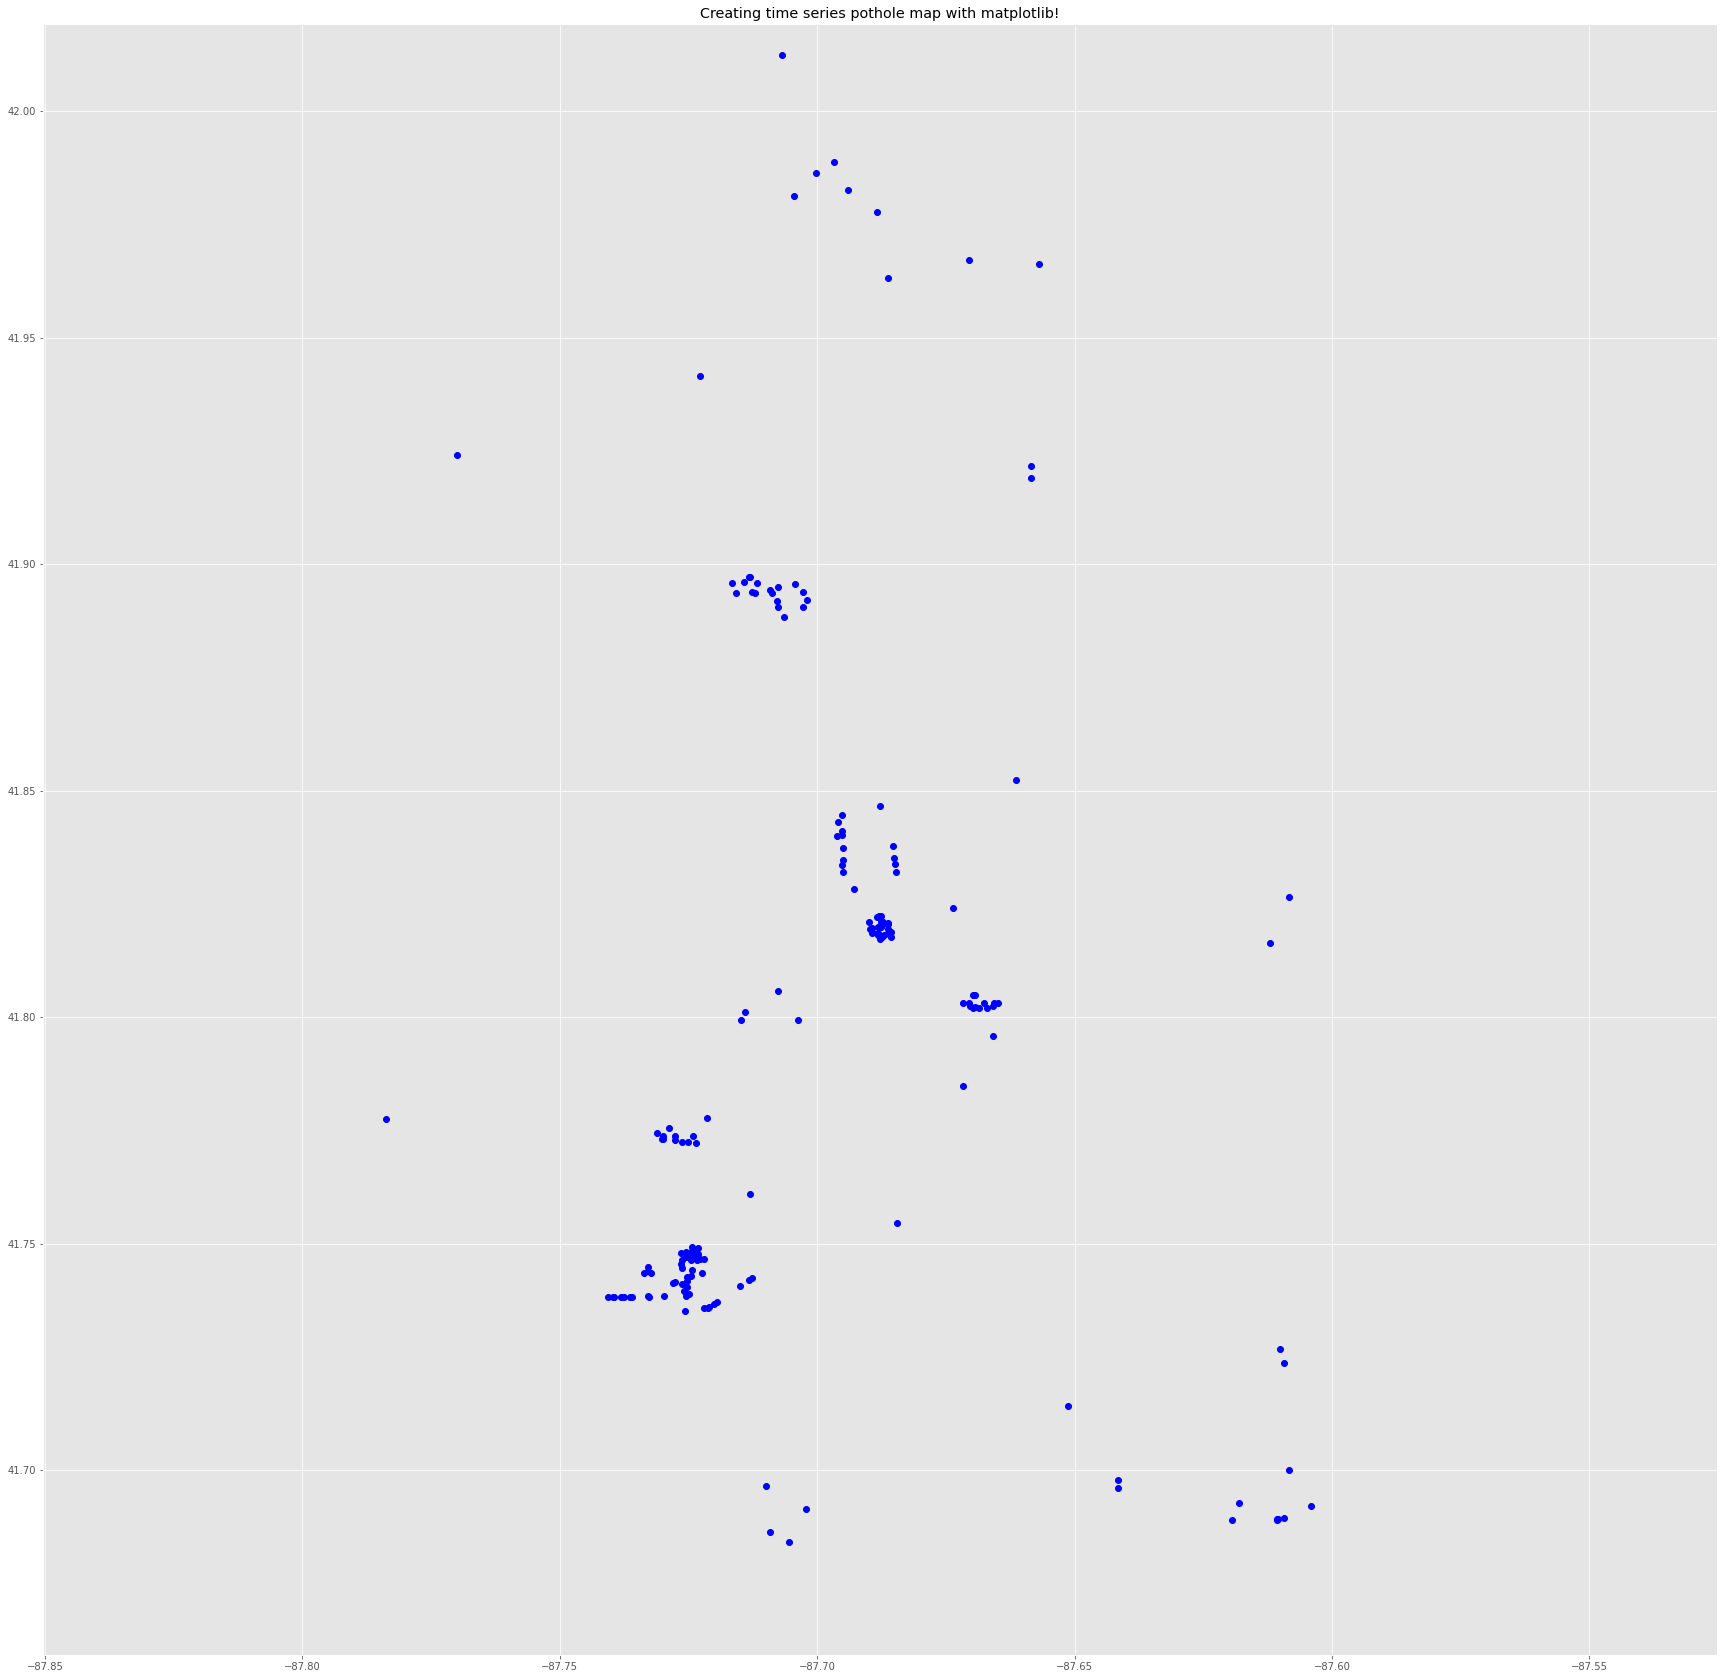

In [131]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('ggplot')
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams["figure.figsize"] = [30, 30]

df = map_arr[-1]
xdata = df["LONGITUDE"].dropna().to_numpy()
ydata = df["LATITUDE"].dropna().to_numpy()
xlim=(min(xdata), max(xdata)) 
ylim=(min(ydata), max(ydata))


xlim = (-87.85041986215067, -87.52523350043245)
ylim = (41.65924455069546, 42.019245840973895)

print(xlim)
print(ylim)

fig = plt.figure()
#plt.scatter(xdata,ydata)
ax = plt.axes(xlim=xlim, ylim=ylim) 
#ax.set_facecolor((1.0, 0.47, 0.42))
sct, = plt.plot([], [],'o', color='blue', lw=2) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    sct.set_data([], [])
    return sct,

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i):
    df = map_arr[i]
    xdata = df["LONGITUDE"].dropna().to_numpy()
    ydata = df["LATITUDE"].dropna().to_numpy()
    sct.set_data(xdata,ydata)
    return sct,

# setting a title for the plot 
plt.title('Creating time series pothole map with matplotlib!') 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.arange(0,len(pothole_count),1), interval=100, blit=True,repeat=False) 

# save the animation as mp4 video file 
anim.save(CSV_PATH + 'potholes_2020.gif', writer='imagemagick') 
#plt.show()

In [132]:
from scipy import stats as st
from scipy.stats import gaussian_kde as gaussian_kde
import numpy as np
from KDEpy import FFTKDE, NaiveKDE


def get_kde( x, y, xmin, xmax, ymin, ymax, xx, yy, positions):

    values = np.array([x, y]).T
    #values = values.reshape(values.shape[1], values.shape[0])
    #print("values is: " + str(values))
    #grid, points = get_kernel(values)
    points = get_kernel(values, positions)
    #kernel.set_bandwidth(bw_method=kernel.factor / 30.)
    f = np.reshape(points, xx.shape)
    #print(points.shape)
    #print(grid)
    #return grid, f
    return f

def get_kernel(data, positions):
    #print(data.shape)
    #print(data)
    estimator = FFTKDE(kernel='gaussian', norm=2, bw=0.001)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    points = estimator.fit(data, weights=None).evaluate(positions)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    #kernel = gaussian_kde(dataset=values, bw_method="silverman" )
    #return grid, points
    return points

In [133]:
grid_size = 1000
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
positions = np.dstack([xx.ravel(), yy.ravel()])
positions = positions.reshape(positions.shape[1], positions.shape[2])
grid_matrix = positions

In [134]:
for i, df in enumerate(map_arr):
    if df["LONGITUDE"].count() > 10:
        #grid, points = get_kde(df["LONGITUDE"].dropna().to_numpy(), df["LATITUDE"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        points = get_kde(df["LONGITUDE"].dropna().to_numpy(), df["LATITUDE"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        density_matrix_t_series.append(points)
        print("@" + str(i))
    

@32
@33
@34
@35
@36
@37
@38
@39
@40
@41
@42


In [135]:
f = open(CSV_PATH +'density_matrix_t_series_2020.pkl', "wb")
dill.dump(density_matrix_t_series, file=f)
f.close()

f = open(CSV_PATH + 'grid_matrix_2020.pkl', "wb")
dill.dump(grid_matrix, file=f)
f.close()